# Лабораторная работа по методам Монте-Карло

В рамках данной работы предлагается:
- Реализовать динамику Ланжевена для сэмплирования из апостериорного распределения
- Реализовать стохастическую динамику Ланжевена для сэмплирования из апостериорного распределения
- Применить оба метода на модельной задаче оценки параметров смеси нормальных распределений
- Применить стохастическую динамику Ланжевена обучения байесовского ансамбля нейросетевых классификаторов

Оценка ставится на основе дополненного кода в ячейках (вычисление градиентов в модельной задаче, динамика Ланжевена и стохастическая динамика Ланжевена), а также ответов на вопросы по экспериментам. Учтите, что на запуск последнего эксперимента может потребоваться около сорока минут.

Полезные источники:

- Welling M., Teh Y. W. Bayesian learning via stochastic gradient Langevin dynamics //Proceedings of the 28th International Conference on Machine Learning (ICML-11). – 2011. – С. 681-688.
- Neal R. M. et al. MCMC using Hamiltonian dynamics //Handbook of Markov Chain Monte Carlo. – 2011. – Т. 2. – №. 11.
- Glorot X., Bengio Y. Understanding the difficulty of training deep feedforward neural networks //Proceedings of the Thirteenth International Conference on Artificial Intelligence and Statistics. – 2010. – С. 249-256.

In [1]:
import matplotlib.pylab as plt
import numpy as np

import copy
import gzip
import os

from urllib.request import urlretrieve
from scipy.stats import norm, uniform
from tqdm import tqdm

%matplotlib inline

# Задача оценки параметров смеси распределений

> Рассмотрим вероятностную модель, в которой данные приходят из смеси нормальных распределений:

>\begin{align}
& \theta_1 \sim N(0,\sigma_1^2); \quad \theta_2 \sim N(0, \sigma_2^2) \\
& \\
& x_i \overset{i.i.d.}{\sim} \frac{1}{2} N(\theta_1, \sigma_x^2) + \frac{1}{2} N(\theta_1 + \theta_2, \sigma_x^2) \quad i=1,\dots,N \\
\end{align}

>На $\theta_1$ и $\theta_2$ введены априорные нормальные распределения, а все остальные параметры полагаются равными
\begin{align}
& \sigma_x^2 = 2 \\
& \sigma_1^2 = 10 \\
& \sigma_2^2 = 1 \\
\end{align}

>Требуется по сгеренированной с параметрами $\theta_1 = 0$, $\theta_2 = 1$ выборке $X$ из $N=100$ элементов построить сэмплы из апостериорного распределения $p({\bar \theta} | X, \sigma_x, \sigma_1, \sigma_2)$.

Построим выборку из данного распределения:

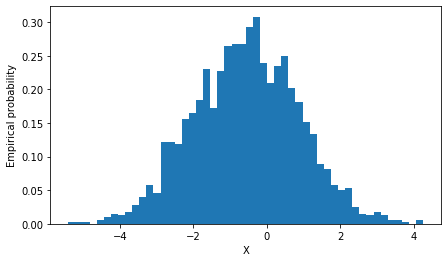

In [2]:
def generate_mixture_data(N, theta_1=None, theta_2=None, seed=6):
    """
    Функция геренирует выобрку данного размера из описанной выше вероятностной модели.
    В случае, когда для theta_1 или theta_2 передано скалярное значение, вместо случайного
    значения параметра из априорного распределения используется переданное значение.
    """
    np.random.seed(seed)
    sigma_x = np.sqrt(2.)
    if theta_1 is None:
        sigma_1 = np.sqrt(10.)
        theta_1 = sigma_1 * np.random.randn()
    if theta_2 is None:
        sigma_2 = 1.
        theta_2 = sigma_2 * np.random.randn()
    mixture_component = np.random.randint(0, 2, N).astype(np.bool)
    first_component = theta_1 + sigma_x * np.random.randn(N)
    second_component = (theta_1 + theta_2) + sigma_x * np.random.randn(N)
    samples = np.where(mixture_component,
                       first_component,
                       second_component)
    return samples

# Пример выборки из описанной выше модели
fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(generate_mixture_data(2048), bins=50, density=True)
ax.set_xlabel('X')
ax.set_ylabel('Empirical probability');

Наша главная цель - по полученной при фиксированных значениях $\theta_1$ и $\theta_2$ выборке построить апостериорное распределение на их значения.

\begin{equation}
p({\bar \theta} | X, \sigma_x, \sigma_1, \sigma_2) \propto \left[ \prod_{i=1}^{N} p(X| {\bar \theta}, \sigma_x) \right] p(\theta | \sigma_1, \sigma_2)
\end{equation}

Хотя задача и допускает аналитический подсчет апостериорного распределения, после раскрытия скобок оно будет представлять из себя смесь $2^N$ нормальных распределений. Поэтому даже для такой простой задачи аналитический вывод может оказаться неэффективным на практике.

Методы Монте-Карло позволяют получить сэмплы из апостериорного распределения. Для наших целей мы заведем класс, который будет:

- хранить точки из апостериорного распределения
- вычислять совместное правдоподобие $p(X, {\bf \theta})$ по выборке $X$
- вычислять градиенты совместного правдоподобия $\nabla_{\theta_i} \log p(X, {\bf \theta})$ по выборке X

> От вас требуется реализовать методы *_prior_gradients* и *likelihood_gradients*. Оба метода возвращают словарь с градиентами с ключами 'theta_1', 'theta_2'. Последний метод возвращает также пару оценок на дисперсии стохастических градиентов $log p(x_{ti} | \bar{\theta})$.

In [3]:
class mixture():
    def __init__(self, theta_1, theta_2):
        """
        Класс инициализируется парой векторов theta_1, theta_2 длины M
        В лабораторной работе мы будем запускать параллельно и независимо M схем Монте-Карло,
        обновляя каждый из M скалярных параметров theta_i
        """
        self.sigma_1 = np.sqrt(10.)
        self.sigma_2 = 1.
        self.sigma_x = np.sqrt(2.)
        self.weights = {'theta_1': theta_1,
                        'theta_2': theta_2}
    
    def joint_likelihood(self, x):
        """
        Для выборки x размера N функция возвращает вектор размера M значений
        log p(X, theta_1[i], theta_2[i]), i=1, ..., M
        """
        x = x[:, None]  # shape [N, 1]
        theta_1 = self.weights['theta_1'][None, :]  # shape [1, M]
        theta_2 = self.weights['theta_2'][None, :]  # shape [1, M]
    
        log_n_1 = norm.logpdf(x, theta_1, self.sigma_x)  # shape [N, M]
        log_n_2 = norm.logpdf(x, theta_1 + theta_2, self.sigma_x)  # shape [N, M]
        log_max = np.where(log_n_1 > log_n_2, log_n_1, log_n_2) # для вычислительной стабильности
    
        log_data = np.sum(
            np.log(0.5 * np.exp(log_n_1 - log_max)
                   + 0.5 * np.exp(log_n_2 - log_max)) + log_max,
            axis=0
        )
        log_prior = (
            norm.logpdf(theta_1, 0, self.sigma_1)
            + norm.logpdf(theta_2, 0, self.sigma_2)
        )[0]
        return log_data + log_prior
    
    def joint_likelihood_gradients(self, x, N_over_n=1.):
        """
        Для выборки подвыборки x размера n и отношешения размера полной выборки к размеру подвыборки N_over_n
        функция возвращает несмещенную оценку на градиент совместного правдоподобия:
        \nabla_\theta_i [ \log p(\theta) + N_over_n * \sum_{i = 1}^n log p(x_{ti} | \theta) ]
        По умолчанию выборка считается полной и N_over_n=1.
        """
        prior = self._prior_gradients()
        likelihood, _ = self.likelihood_gradients(x)
        joint = {}
        for key in prior.keys():
            joint[key] = prior[key] + N_over_n * likelihood[key]
        return joint
        
    def _prior_gradients(self):
        """
        Возвращает градиенты априорного распределения \nabla_{\theta_j} \log p(\theta)
        """
        ####################
        # Допишите функцию #
        ####################
        d_theta_1 = -1. * (self.weights['theta_1'] / self.sigma_1**2)
        d_theta_2 = -1. * (self.weights['theta_2'] / self.sigma_2**2)
        
        return {'theta_1': d_theta_1, 'theta_2': d_theta_2}
    
    def likelihood_gradients(self, x):
        """
        Для выборки x размера n возвращает
        1. Градиенты \nabla_{\theta_j} [\sum_{i=1}^n \log p(x_{ti} | \theta)]
        2. Пару чисел с оценкой на дисперисю градиента \nabla_{\theta_j} \log p(x_{ti} | \theta)
        относительно взятия случайной подвыборки x (например, среднее по параллельным запускам)
        """
        ####################
        # Допишите функцию #
        ####################
        x = x[:, None]  # shape [n, 1]
        theta_1 = self.weights['theta_1'][None, :]  # shape [1, M]
        theta_2 = self.weights['theta_2'][None, :]  # shape [1, M]
        
        exponents_1 = np.exp(-1. * (x - theta_1)**2 / (2*self.sigma_x**2))
        exponents_2 = np.exp(-1. * (x - theta_1 - theta_2)**2 / (2*self.sigma_x**2))
        exp_deriv_1 = (x - theta_1) / self.sigma_x**2
        exp_deriv_2 = (x - theta_1 - theta_2) / self.sigma_x**2
        
        d_theta_1 = np.sum((exp_deriv_1 * exponents_1 + exp_deriv_2 * exponents_2) / (exponents_1 + exponents_2), axis=0)
        d_theta_2 = np.sum(exp_deriv_2 * exponents_2 / (exponents_1 + exponents_2), axis=0)
        
        var_theta_1 = np.std(d_theta_1)
        var_theta_2 = np.std(d_theta_2)
        
        return {'theta_1': d_theta_1, 'theta_2': d_theta_2}, (var_theta_1, var_theta_2)

Согласно задаче, к нам поступает полученная со значениями $\theta_1=0$ и $\theta_2=1$ выборка из ста наблюдений $x_i$.

Изобразим приближенно плотность аспостериорного распределения в зависимости от числа поступивших наблюдений:

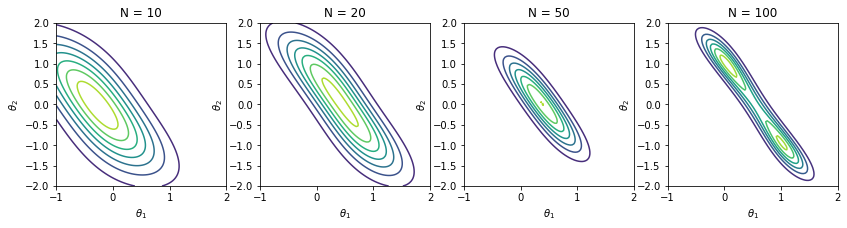

In [4]:
N = 100
data = generate_mixture_data(N, theta_1=0, theta_2=1, seed=6)

def plot_posterior(axes, data, resolution=100):
    theta_1 = np.linspace(-1., 2., resolution)
    theta_2 = np.linspace(-2., 2., resolution)
    X, Y = np.meshgrid(theta_1, theta_2)
    model = mixture(X.reshape(-1), Y.reshape(-1))
    Z = np.exp(model.joint_likelihood(data))
    norm_const = np.sum(Z) * 3 * 4 / resolution ** 2
    Z /= norm_const
    Z = Z.reshape((resolution, resolution))

    CS = axes.contour(X, Y, Z)
    axes.set_xlabel(r'$\theta_1$')
    axes.set_ylabel(r'$\theta_2$')

Ns = [10, 20, 50, 100]
fig, axes = plt.subplots(ncols=len(Ns), figsize=(14, 3))
data = generate_mixture_data(100, theta_1=0, theta_2=1, seed=6)
for n, ax in zip(Ns, axes):
    plot_posterior(ax, data[:n])
    ax.set_title('N = %d' % n)

> У апостериорного распределения на последнем графике можно заметить две ярко выраженные моды. Чем это можно объяснить?

Можно заметить, что если $\theta_1 = 1$, а $\theta_2 = -1$, то распределение не изменяется, т.е. существует некоторая симметрия. Поэтому возникает две моды

> Ниже необходимо реализовать функции для построения сэмплов из апостериорного распределения:

> 1. Стохастическая динамика Ланжевена. Для реализации достаточно слегка модифицировать предложенную реализацию градиентного подъема
> 2. Динамика Ланжевена с приятием точек по схеме Метрополиса-Гастингса
    - Вычисление новых весов
    - Подсчет вероятности их принятия (возможно, потребуется создать копию model)
    - Случайное принятие части весов

In [5]:
import math

def gradient_ascent(x, model, epsilon_t, N_over_n=1.):
    """
    Метод (стохастического) градиентного подъема
    """
    gradients = model.joint_likelihood_gradients(x, N_over_n)
    for key in model.weights.keys():
        model.weights[key] += 0.5 * epsilon_t * gradients[key]

        
def stochastic_langevin_update(x, model, epsilon_t, N_over_n):
    """
    Обновление весов модели model согласно стохастической динамике Ланжевена по подвыборке x размера n,
    с шагом epsilon_t
    """
    ####################
    # Допишите функцию #
    ####################
    
    num_params = len(model.weights.keys())
    
    M = model.weights[next(iter(model.weights.keys()))].shape[0]
    
    gradients = model.joint_likelihood_gradients(x, N_over_n)
    
    for i, key in enumerate(model.weights.keys()):
        M = model.weights[key].shape
        d_Bt_i = norm.rvs(scale=math.sqrt(epsilon_t), size=M)
        model.weights[key] += 0.5 * epsilon_t * gradients[key] + d_Bt_i
    

def langevin_update(x, model, epsilon):
    """
    Обновление весов модели model согласно динамике Ланжевена по выборке x.
    Возвращает число от 0 до 1, долю принятых точек из M параллельных запусков динамики.
    """
    ####################
    # Допишите функцию #
    ####################
    
    num_accepted = 0
    M = model.weights[next(iter(model.weights.keys()))].shape[0]

    proposed_model = copy.deepcopy(model)  # or smth to copy model
    
    # Обновление весов для предлагаемого положения
    stochastic_langevin_update(x, proposed_model, epsilon, 1.)
        
    proposed_model_probs = proposed_model.joint_likelihood(x)
    old_model_probs = model.joint_likelihood(x)
    acceptance_probs = np.minimum(np.exp(proposed_model_probs - old_model_probs), 1)
    alpha = uniform.rvs(size=M)
    
    accepted_parameters_indices = np.where(acceptance_probs >= alpha)[0]
    portion_accepted = len(accepted_parameters_indices) / M
    
    for i, key in enumerate(model.weights.keys()):
        model.weights[key] = np.where(acceptance_probs >= alpha, proposed_model.weights[key], model.weights[key])
    
    return portion_accepted

## Динамика Ланжевена на модельной задаче

Для проведения эксперимента определим несколько вспомогательных функций

In [6]:
def append_ema(array, value, alpha=0.05):
    """
    Добавление элементов в массив с экспоненциальным сглаживанием
    """
    if not array:
        array.append(value)
    else:
        array.append((1 - alpha) * array[-1] + alpha * value)
    return array

def train_mixture(data, model, epsilon, n_epochs=2000, n_trajectories=5):
    """
    Построение точек из апостериорного распределения с помощью динамики Ланжевена
    Параллельно с построением точек сохраняются траектории n_trajectories точек и динамика
    acceptance_rate
    """
    acceptance_rate = []
    theta_1_dynamics = []
    theta_2_dynamics = []
    for epoch in tqdm(range(n_epochs)):
        theta_1_dynamics.append(np.copy(model.weights['theta_1'][:n_trajectories]))
        theta_2_dynamics.append(np.copy(model.weights['theta_2'][:n_trajectories]))
        append_ema(acceptance_rate, langevin_update(data, model, epsilon))
    theta_1_dynamics = np.asarray(theta_1_dynamics)
    theta_2_dynamics = np.asarray(theta_2_dynamics)
    return acceptance_rate, theta_1_dynamics, theta_2_dynamics

Запустим M схем Ланжевена с шагом $\varepsilon = 10^{-3}$ и с шагом $\varepsilon = 10^{-4}$

In [7]:
M = 100

model_a = mixture(np.random.randn(M), np.random.randn(M))
model_b = mixture(np.random.randn(M), np.random.randn(M))

acceptance_rates_a, theta_1_dynamics_a, theta_2_dynamics_a = train_mixture(data, model_a, 1e-3, 2000)
acceptance_rates_b, theta_1_dynamics_b, theta_2_dynamics_b = train_mixture(data, model_b, 1e-4, 2000)

100%|██████████| 2000/2000 [00:13<00:00, 145.24it/s]


В следующей ячейке строится четыре графика:
1. Два множества M точек из параллельно запущенных динамик Ланжевена после 2000 итераций
2. Динамика пяти точек из схемы с шагом $\varepsilon=10^{-3}$
3. Динамика пяти точек из схемы с шагом $\varepsilon=10^{-4}$
4. Доля принятых точек (из M параллельных динамик) после каждой итерации для разных шагов

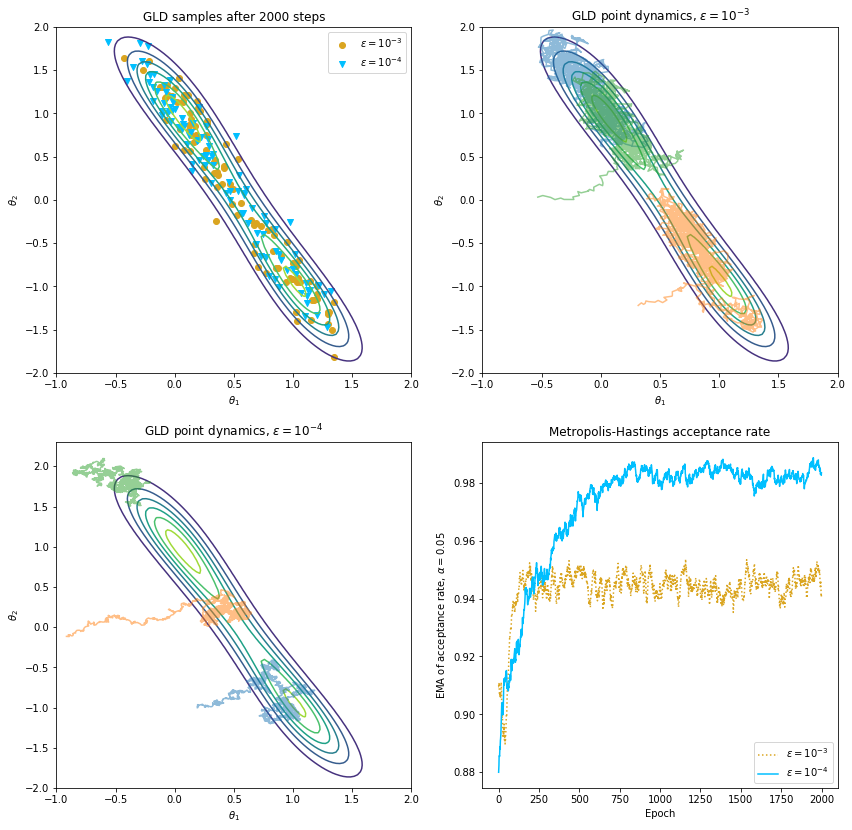

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))

plot_posterior(axes[0][0], data)
axes[0][0].scatter(model_a.weights['theta_1'],
                model_a.weights['theta_2'],
                marker='o',
                c='goldenrod',
                label=r'$\varepsilon=10^{-3}$')
axes[0][0].scatter(model_b.weights['theta_1'],
                model_b.weights['theta_2'],
                marker='v',
                c='deepskyblue',
                label=r'$\varepsilon=10^{-4}$')
axes[0][0].set_title('GLD samples after 2000 steps')
axes[0][0].legend(loc='upper right')

plot_posterior(axes[0][1], data)
plot_posterior(axes[1][0], data)
axes[0][1].set_title(r'GLD point dynamics, $\varepsilon=10^{-3}$')
axes[1][0].set_title(r'GLD point dynamics, $\varepsilon=10^{-4}$')

for i in range(2, 5):
    axes[0][1].plot(theta_1_dynamics_a[:, i], theta_2_dynamics_a[:, i], alpha=0.5)
    axes[1][0].plot(theta_1_dynamics_b[:, i], theta_2_dynamics_b[:, i], alpha=0.5)

axes[1][1].plot(acceptance_rates_a, label=r'$\varepsilon=10^{-3}$', ls=':', c='goldenrod')
axes[1][1].plot(acceptance_rates_b, label=r'$\varepsilon=10^{-4}$', ls='-', c='deepskyblue')
axes[1][1].set_title('Metropolis-Hastings acceptance rate')
axes[1][1].set_xlabel('Epoch')
axes[1][1].set_ylabel(r'EMA of acceptance rate, $\alpha = 0.05$')
axes[1][1].legend(loc='lower right');

> На основе этих графиков ответьте на следующие вопросы:
- Хорошо ли точки покрывают апостериорное распределение?
- Удается ли точкам "перепрыгнуть" с одной моды на другую?
- Как меняется доля принятых точек в зависимости от величины шага?
- Исходя из каких соображений стоит выбирать длину шага в динамике Ланжевена?

1. Нельзя сказать, что полученные цепи поотдельности хорошо описывают распределение. Однако, если объединить сэмплы нескольких цепочек в один, то можно сказать, что полученные при $\varepsilon$ = 1e-3 точки достаточно хорошо описывают распределение.
2. Можно сказать, что как для $\varepsilon$ = 1e-4, так и для $\varepsilon$ = 1e-3 сэмплеру удаётся перепрыгнуть с одной моды, на другую. Однако можно заметить, что при $\varepsilon$ = 1e-3 сэмплер гораздо чаще перепрыгивает с одной моды на другую, а при $\varepsilon$ = 1e-4 сэмплер достаточно долго находится в одной моде и, видимо, 10000 шагов ему не хватает, чтобы описать выборку
3. Если смотреть на долю принятых точек после warm-up'а, то для модели сэмплера с меньшим $\varepsilon$ доля принятых точек больше
4. Возможно, перед тем как генерировать выборку, стоит оценить характерные размеры распределения и градиенты. Затем воспользоваться некоторыми эвристиками, например задать $\varepsilon$ таким образом, чтобы $||\varepsilon \cdot grad||$ ранялось характерному размеру

## Стохастическая динамика Ланжевена на модельной задаче

Для проведения следующего эксперимента определим еще несколько вспомогательных функций

In [9]:
def iterate_data(length, batchsize=100, shuffle=True):
    """
    Функция для прохода по выборке
    """
    indices = np.arange(length)
    if shuffle:
        np.random.shuffle(indices)
    for start_idx in range(0, length - batchsize + 1, batchsize):
        yield indices[start_idx:start_idx + batchsize]

def stochastic_train_mixture(data, model, method, n_epochs=2000, n=10, n_trajectories=5):
    """
    Построение точек из апостериорного распределения с помощью стохастической динамики Ланжевена
    Параллельно с построением точек сохраняются траектории n_trajectories точек после каждой эпохи,
    оценки дисперий стохастического градиента и дисперсия добавочного шума динамики Ланжевена
    """
    noise_vars = []
    theta_1_vars = []
    theta_2_vars = []
    theta_1_dynamics = []
    theta_2_dynamics = []
    N_over_n = len(data) / n
    steps_counter = 0
    for epochs in tqdm(range(n_epochs)):
        epsilon = 1e-2 * (steps_counter + 1e2) ** (-0.55)
        for indices in iterate_data(len(data), n):
            method(data[indices], model, epsilon, N_over_n)
            steps_counter += 1
    
        theta_1_dynamics.append(np.copy(model.weights['theta_1'][:n_trajectories]))
        theta_2_dynamics.append(np.copy(model.weights['theta_2'][:n_trajectories]))
        # также как и в статье, оцениваем дисперсии по подвыборке
        _, theta_vars = model.likelihood_gradients(data[np.random.choice(N, n)])
        theta_1_vars.append(theta_vars[0] * (0.5 * epsilon * N_over_n) ** 2 * n)
        theta_2_vars.append(theta_vars[1] * (0.5 * epsilon * N_over_n) ** 2 * n)
        noise_vars.append(epsilon)
        
    theta_1_dynamics = np.asarray(theta_1_dynamics)
    theta_2_dynamics = np.asarray(theta_2_dynamics)
    
    return noise_vars, theta_1_vars, theta_2_vars, theta_1_dynamics, theta_2_dynamics

Запустим стохастическую динамику Ланжевена и стохастический градиентный подъем

In [10]:
n = 10
M = 10 # mcmc chains to run in parallel
n_trajectories = 5

model_a = mixture(np.random.randn(M), np.random.randn(M))
model_b = mixture(np.random.randn(M), np.random.randn(M))

noise_vars_a, theta_1_vars_a, theta_2_vars_a, theta_1_dynamics_a, theta_2_dynamics_a = stochastic_train_mixture(
    data, model_a, stochastic_langevin_update, n_epochs=2000, n=n
)

_, theta_1_vars_b, theta_2_vars_b, theta_1_dynamics_b, theta_2_dynamics_b = stochastic_train_mixture(
    data, model_b, gradient_ascent, n_epochs=2000, n=n
)

100%|██████████| 2000/2000 [00:04<00:00, 484.17it/s]


В следующей ячейке строятся четыре графика:

1. M точек из параллельно запущенных динамик Ланжевена после 2000 эпох и M точек из параллельно замущенных стохастических градиентных спусков после 2000 эпох
2. Траектории пяти точек при движении согласно стохастической динамике Ланжевена
3. Траектории пять точек при движении в направлении стохастического градиента
4. Дисперсии стохастических градиентов и добавочного шума стохастической динамики Ланжевена в зависимости от эпохи

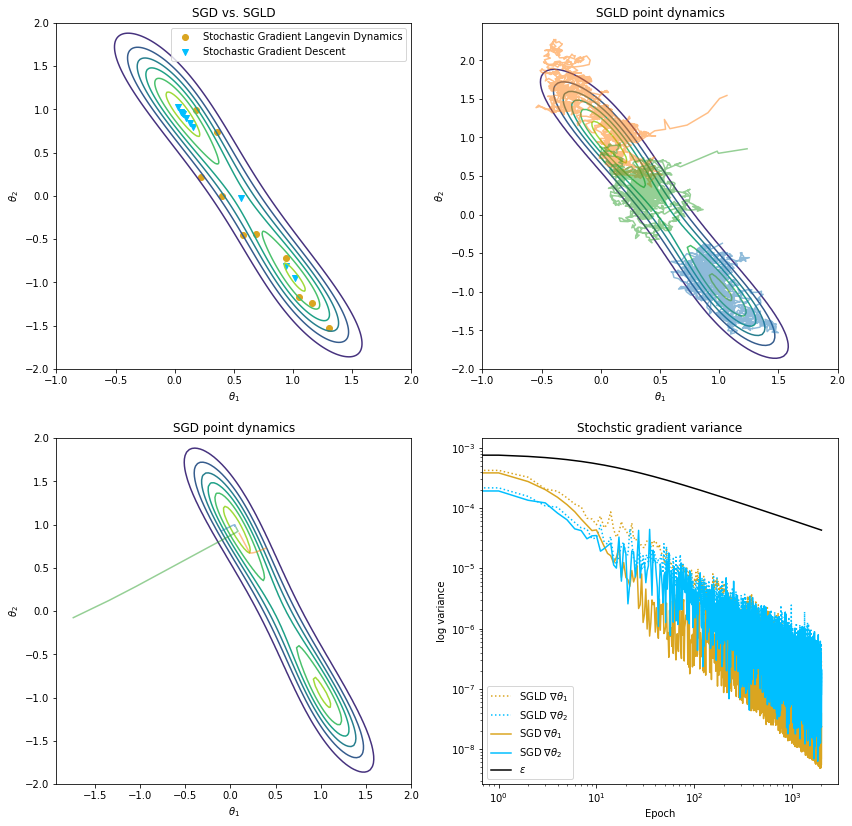

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))

plot_posterior(axes[0][0], data, 200)
axes[0][0].scatter(model_a.weights['theta_1'],
                   model_a.weights['theta_2'],
                   c='goldenrod',
                   label='Stochastic Gradient Langevin Dynamics')
axes[0][0].scatter(model_b.weights['theta_1'],
                   model_b.weights['theta_2'],
                   marker='v',
                   c='deepskyblue',
                   label='Stochastic Gradient Descent')
axes[0][0].set_title('SGD vs. SGLD')
axes[0][0].legend(loc='upper right')

plot_posterior(axes[0][1], data)
plot_posterior(axes[1][0], data)
axes[0][1].set_title(r'SGLD point dynamics')
axes[1][0].set_title(r'SGD point dynamics')

for i in range(3):
    axes[0][1].plot(theta_1_dynamics_a[:, i], theta_2_dynamics_a[:, i], alpha=0.5)
    axes[1][0].plot(theta_1_dynamics_b[:, i], theta_2_dynamics_b[:, i], alpha=0.5)

axes[1][1].set_title('Stochstic gradient variance')
axes[1][1].set_yscale("log", nonposy='clip')
axes[1][1].set_xscale("log", nonposx='clip')
axes[1][1].plot(theta_1_vars_a, label=r'SGLD $\nabla \theta_1$', c='goldenrod', ls=':')
axes[1][1].plot(theta_2_vars_a, label=r'SGLD $\nabla \theta_2$', c='deepskyblue', ls=':')
axes[1][1].plot(theta_1_vars_b, label=r'SGD $\nabla \theta_1$', c='goldenrod', ls='-')
axes[1][1].plot(theta_2_vars_b, label=r'SGD $\nabla \theta_2$', c='deepskyblue', ls='-')
axes[1][1].plot(noise_vars_a, label=r'$\varepsilon$', c='black')
axes[1][1].set_xlabel('Epoch')
axes[1][1].set_ylabel('log variance')
axes[1][1].legend(loc='lower left');

> На основе графиков ответьте на следующие вопросы:
1. Хорошо ли представленные точки покрывают апостериорное распределение? Где собираются точки после градиентного подъема?
3. Удается ли стохастической динамике Ланжевена "перепрыгнуть" с одной моды на другую?
4. Как соотносятся дисперсии стохастических градиентов с дисперсией добавленного шума динамики Ланжевена?

1. В стохастическом варианте динамики Ланжевена, точки достаточно хорошо описывают распределение. Полученные оценки максимума апостериорного распределения завися от начальной точки.
2. Для данных параметров удаётся и достаточно часто.
3. Дисперсия стохастических градиентов меньше, чем дисперсия добавленного шума. Можно отметить, что они соотносятся с точностью до константы

## Обучение нейросетевых классификаторов с использованием стохастической динамики Ланжевена

> Изучив свойства метода на модельной задаче, попробуем с его помощью обучить небольшой классификатор на данных MNIST. Для этого сначала введем вероятностную модель:
- Вероятности классов $p(y | X, \bar{W})$ будет определяться выходами нейронной сети $F(X, \bar{W})$ с параметрами $\bar{W}$
- В качестве априорного распределения $p(W_i)$ на веса $i$-го слоя $W_i$ будем использовать нормальное распределение $\mathcal{N}(0, s_i I)$. Ковариация будем определяться размерами матрицы весов слоя $$ s_i = 2 (d_i^{in} + d_i^{out})^{-1}, $$ а для векторов смещения будем полагать $d_i^{in}=0$. Такое распределение часто используется при инициализации весов сети по схеме Глорота.

> С точки зрения байесовской статистики наиболее обоснованным подходом к обучению классификатора является построение распределения 
\begin{align}
p(y' | X', y, X) = \mathbb E_{p(\bar{W} | y, X)} p(y' | X', \bar{W})
\end{align}

> К сожалению, для выбранной модели аналитический байесовский вывод невозможен даже на бумаге, поэтому попробуем найти распределение приближенно. В этой работе мы расмотрим два подхода:
1. Замена математического ожидания на MAP оценку: $$p(y' | X', y, X) \approx p(y' | X', \bar{W}^{MAP}).$$ Здесь ${\bar W}^{MAP}$ - точка максимума плотности апостериорного распределения.
2. Монте-Карло оценка распределения: $$p(y' | X', y, X) \approx \frac{1}{N} \sum_{i=1}^N p(y' | X', \bar{W}^i), \quad \bar{W}^i \sim p(\bar{W} | y, X)$$

Для экспериментов снова определим класс с параметрами модели:

In [12]:
class nnClassifier():
    def __init__(self, architecture, batchsize):
        """
        Класс для простой нейронной сети, размеры слоев определяются последовательностью architecture.
        При инициализации создается batchsize нейронных сетей, это позволяет в экспериментах одновременно
        запускать несколько независимых схем Ланжевена.
        """
        self.batchsize = batchsize
        self.depth = len(architecture) - 1
        self.architecture = architecture
        self.weights = self._glorot_weight_initializer(self.batchsize)
        self.gradients = {}
    
    def predict(self, x, nets_to_use=None):
        """
        Возвращает вектор вероятностей \sum_{i=1}^N p(y | X, W^i)
        Если значение nets_to_use не передано, усреднение берется по всем сетям в классе,
        В противном случае используются первые N=nets_to_use сетей
        """
        predictions = self._softmax(self._forward_backward_pass(x, None, False))
        nets_to_use = nets_to_use if nets_to_use else self.batchsize
        return np.mean(predictions[:, :nets_to_use], axis=1)
    
    def joint_likelihood_gradients(self, x_and_y, N_over_n):
        # joint likelihood gradient
        """
        Для выборк x_and_y возвращает несмещенную оценку на градиент совместного правдоподобия
        """
        x, y = x_and_y
        self._forward_backward_pass(x, y, True)
        self._add_grolot_prior_gradients(N_over_n)
        return self.gradients
                                    
    def _glorot_weight_initializer(self, batchsize):
        """
        Инициализация весов нейронной сети по схеме Глорота
        """
        weights = {}
        for i, d_in, d_out in (zip(range(self.depth),
                                   self.architecture[:-1],
                                   self.architecture[1:])):
            std_w = np.sqrt(2 / (d_out + d_in))
            std_b = np.sqrt(2 / (d_out))
            W = std_w * np.random.randn(batchsize, d_out, d_in)
            b = std_b * np.random.randn(batchsize, d_out)
            weights['W_' + str(i)] = W
            weights['b_' + str(i)] = b
        return weights
                                                            
    def _softmax(self, activations):
        """
        Вычисление вероятностей по выходам линейного слоя сети
        """
        logit_min = np.min(activations, axis=2, keepdims=True)
        logit_exp = np.exp(activations - logit_min)
        norm_const = np.sum(logit_exp, axis=2, keepdims=True)
        return logit_exp / norm_const
    
    def _forward_backward_pass(self, x, y, backward_pass):
        """
        Прямой и обратный проход по вычислительному графу. Выполняет прямой проход
        по графу вычислений. Если backward_pass=False, возвращает активации последнего слоя.
        В противном случае с использованием y выполняет обратный проход, вычисляя градиенты
        правдоподобия модели. Затем возвращает активации последнего слоя и градиенты правдоподобия.
        """
        # Forward pass
        activations = [x[:, None, :]]
        for i in range(self.depth - 1):
            W = self.weights['W_' + str(i)]
            b = self.weights['b_' + str(i)]
            linear = np.einsum('ikj,klj->ikl', activations[-1], W) + b[None, ...]
            activations.append(np.tanh(linear))
            #activations.append(np.where(linear >= 0, linear, 0))
        else:
            W = self.weights['W_' + str(self.depth - 1)]
            b = self.weights['b_' + str(self.depth - 1)]
            output = np.einsum('ikj,klj->ikl', activations[-1], W) + b[None, ...]
        
        if not backward_pass:
            return output
        # Backward pass
        reverse_activation = y[:, None, :] - self._softmax(output)
        for i in range(self.depth - 1, -1, -1):
            W = self.weights['W_' + str(i)]
            self.gradients['W_' + str(i)] = np.einsum('ikj,ikl->klj',
                                                      activations[i],
                                                      reverse_activation)
            self.gradients['b_' + str(i)] = np.einsum('ikl->kl',
                                                      reverse_activation)
            reverse_activation = (
                (1 - activations[i] ** 2)
                #np.where(activations[i] >= 0, 1, 0)
                * np.einsum('klj,ikl->ikj', W, reverse_activation)
            )
            
        return output, self.gradients
    
    def _add_grolot_prior_gradients(self, N_over_n):
        """
        Масштабирует градиенты правдоподобия, добавляя градиенты априорного распределения
        """
        for i, d_in, d_out in (zip(range(self.depth),
                                   self.architecture[:-1],
                                   self.architecture[1:])):
            std_w = np.sqrt(2 / (d_out + d_in))
            std_b = np.sqrt(2 / (d_out))
            W = self.weights['W_' + str(i)]
            b = self.weights['b_' + str(i)]
            self.gradients['W_' + str(i)] *= N_over_n
            self.gradients['W_' + str(i)] -= W / std_w ** 2
            self.gradients['b_' + str(i)] *= N_over_n
            self.gradients['b_' + str(i)] -= b / std_b ** 2

Определим еще пару вспомогательных функций. Для загрузки данных,

In [13]:
def load_mnist():
    # Загружаем данные
    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)
    
    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        data = data.reshape(-1, 28 * 28)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        data = np.eye(10)[data]
        return data

    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    return X_train, y_train, X_test, y_test

построения MAP оценки,

In [14]:
def train_map(load_dataset, net, n_epochs=64, n=100):
    x_train, y_train, x_test, y_test = load_dataset()
    
    N_over_n = x_train.shape[0] / n

    network_accuracies = []
    
    steps_counter = 0
    for epoch in tqdm(range(n_epochs)):
        # Training
        for indices in iterate_data(len(x_train), batchsize=n):
            steps_counter += 1
            epsilon = 1e-3 * (steps_counter + 1) ** (-0.55)
            gradient_ascent((x_train[indices], y_train[indices]), net, epsilon, N_over_n)
        # Evaluating
        network_accuracy = 0
        for indices in iterate_data(len(x_test), batchsize=n, shuffle=False):
            net_predictions = net.predict(x_test[indices], 1)
            network_accuracy += np.sum(
                np.argmax(net_predictions, axis=1) == np.argmax(y_test[indices], axis=1)
            ) 
        network_accuracy /= y_test.shape[0]
        network_accuracies.append(network_accuracy)
    
    return network_accuracies

и обучения ансамбля с помощью стохастической динамики Ланжевена.

In [15]:
def train_networks(load_dataset, net, n_epochs=64, n_warmup_epochs=16, n=100):
    x_train, y_train, x_test, y_test = load_dataset()

    N_over_n = x_train.shape[0] / n

    network_accuracies = []
    ensemble_accuracies = []
    big_ensemble_accuracies = []
    big_ensemble_predictions = np.zeros((y_test.shape[0], 10))

    steps_counter = 0
    
    for epoch in tqdm(range(n_epochs)):
        # Training
        for indices in iterate_data(len(x_train), batchsize=n):
            steps_counter += 1
            epsilon = 1e-3 * (steps_counter + 1) ** (-0.55)
            stochastic_langevin_update((x_train[indices], y_train[indices]), net, epsilon, N_over_n)
        # Evaluating
        network_accuracy = 0
        ensemble_accuracy = 0
        big_ensemble_accuracy = 0
        for indices in iterate_data(len(x_test), batchsize=n, shuffle=False):
            net_predictions = net.predict(x_test[indices], 1)
            ensemble_predictions = net.predict(x_test[indices])
            
            network_accuracy += np.sum(
                np.argmax(net_predictions, axis=1) == np.argmax(y_test[indices], axis=1)
            )
            ensemble_accuracy += np.sum(
                np.argmax(ensemble_predictions, axis=1) == np.argmax(y_test[indices], axis=1)
            )
            if epoch >= n_warmup_epochs:
                big_ensemble_predictions[indices] += (
                    ensemble_predictions - big_ensemble_predictions[indices]
                ) / (epoch - n_warmup_epochs + 1)
                big_ensemble_accuracy += np.sum(
                    np.argmax(big_ensemble_predictions[indices], axis=1) == np.argmax(y_test[indices], axis=1)
                )
 
        network_accuracy /= y_test.shape[0]
        network_accuracies.append(network_accuracy)
        
        ensemble_accuracy /= y_test.shape[0]
        ensemble_accuracies.append(ensemble_accuracy)
        
        if epoch >= n_warmup_epochs:
            big_ensemble_accuracy /= y_test.shape[0]
            big_ensemble_accuracies.append(big_ensemble_accuracy)
    
    return network_accuracies, ensemble_accuracies, big_ensemble_accuracies

Мы параллельно запускаем $M$ динамик Ланжевена, следуем динамике $T$ эпох. Веса $m$-ой сети после $t$-ой эпохи обозначим за $\bar{W}^{mt}$. Приближение $p(y' | X', y, X)$ с помощью сэмплов из апостериорного распределения мы будем строить тремя способами:

1. Точечная оценка $$q_1(y) = p(y' | X', W^{mt})$$
2. Среднее по независимым запускам $$q_2(y) = \frac{1}{M} \sum_{m=1}^M p(y' | X', W^{mt})$$
3. Среднее по независимым запускам и эпохам с момента $t_0$ $$q_3(y) = \frac{1}{M(t - t_0)} \sum_{m=1}^M \sum_{t'=t_0}^{t} p(y' | X', W^{mt'})$$

Для экономии памяти при вычислении третьей оценки мы будем хранить лишь среднее выходов сети на тестовой выборке с момента t_0 до t'.

In [16]:
n_epochs = 96
n_warmup_epochs = 16 # t_0 в оценке q_3

net_map = nnClassifier(architecture=(28 * 28, 18, 14, 10), batchsize=1)
net_post = nnClassifier(architecture=(28 * 28, 18, 14, 10), batchsize=5) # M = 5 в оценке q_2 и q_3

map_net = train_map(load_mnist, net_map, n_epochs)
post_net, post_ensemble, post_big_ensemble = train_networks(
    load_mnist, net_post, n_epochs, n_warmup_epochs
)

100%|██████████| 96/96 [50:52<00:00, 31.79s/it]


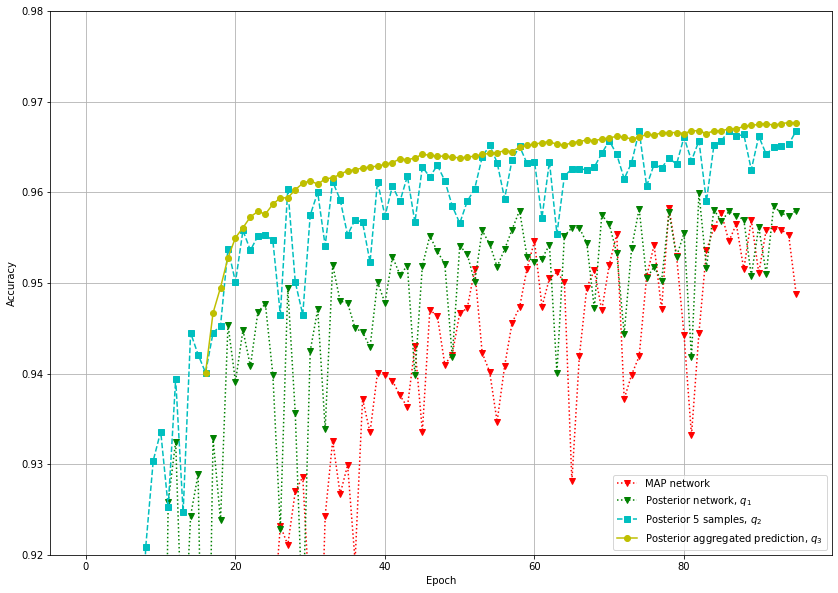

In [17]:
fig, ax = plt.subplots(figsize=(14, 10))

ax.plot(map_net, label='MAP network', marker='v', c='red', ls=':')
#ax.plot(map_ensemble, label='MAP 5 estimates average', marker='s', c='coral', ls='--')
#ax.plot(np.arange(n_warmup_epochs, n_epochs), map_big_ensemble, marker='o',
#        label='MAP aggregated prediction', c='y', ls='-')
ax.plot(post_net, label='Posterior network, $q_1$', marker='v', c='g', ls=':')
ax.plot(post_ensemble, label='Posterior 5 samples, $q_2$', marker='s', c='c', ls='--')
ax.plot(np.arange(n_warmup_epochs, n_epochs), post_big_ensemble, marker='o',
        label='Posterior aggregated prediction, $q_3$', c='y', ls='-')

ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')

ax.grid(True)

ax.set_ylim((0.92, 0.98))
ax.legend(loc='lower right');

> Прокомментируйте результаты экспериментов. Какая из оценок показывает лучшую точность? Худшую? Можно ли сказать, что качество растет с количеством используемых для предсказания моделей?

По результатам эксперимента, можно отметить, что оценка максимума апостериори в целом хуже, чем оценки полученные по сэмплам из апостериорного распределения. Не очень понимаю, почему эта оценка хуже, чем оценка полученная всего по одному сэмплу из апостериорного распределения. Видимо в данном случае бимодальность и симметричность распределения играет большую роль.

Примечательно, что для предсказания, полученного по пяти сэмплам из апостериорного распределения точность определения выше даже при большом числе эпох.

Предсказания, полученные по агрегированным оценкам выглядят, как некоторая верхняя оценка на качество данной архитектуры.